In [1]:
import pyboard
import time
import json
import numpy as np
from pylab import *
from tqdm import tqdm
import os
import pickle
%matplotlib inline

In [2]:
def unPickle(filename):
    '''
    to shorten 3 lines into 1 line
    '''
    with open(filename,'rb') as f:
        output = pickle.load(f)
    f.close()
    return output

def makePickle(filename,data):
    with open(filename,'wb') as f:
        pickle.dump(data,f)
    f.close()

## in Linux
### find the USB-port for the EPS32

In [3]:
gc_cmd = ['import gc','gc.collect()']

In [4]:
result = os.popen('ls -l /dev/ttyUSB*').read()
result = result.strip('\n').split(' ')
port = result[-1]
print(port)

/dev/ttyUSB0


In [5]:
def run_on_board(code, wait_s=0, no_print=False):
    for ln in code:
        res = pb.exec(ln)
        if len(res) > 0 and not no_print:
            res = res[:-2].decode()
            print(res)
    if wait_s > 0:
        time.sleep(wait_s)        
    return res        

pb = None
try:
    pb = pyboard.Pyboard(port)
    pb.enter_raw_repl()  
except pyboard.PyboardError as e:
    print(e)     

In [6]:
script = [
    'from scanner import Scanner',
    'sc = Scanner(verbose=False)'
]
tmp = run_on_board(script, wait_s=0.4, no_print=False)

c,_|Initializing ...
Servo at pin 27 (50 Hz) ready.
Servo at pin 33 (50 Hz) ready.
c,_|Servo manager ready
c,_|Spectrometer ready


In [7]:
dx,dy= (80,80)       # Dimension of the image
sx,sy = (2,2)          # Step size in [°]
nPix = (dx//sx+1)*(dy//sy+1)
tInt_s = 0.005      # Integration time in seconds
fname = ""          # File name, keep empty if only temporary

header = {}
wavelengths_nm = None

s = "({0},{1}), ({2},{3}), {4},{5}".format(dx, dy, sx, sy, tInt_s,1)

In [8]:
s

'(80,80), (2,2), 0.005,1'

In [9]:
def update_header(header_dict):
    year = time.localtime().tm_year
    month = time.localtime().tm_mon
    day = time.localtime().tm_mday
    hour = time.localtime().tm_hour
    mins = time.localtime().tm_min
    sec = time.localtime().tm_sec
    header_dict['date_yyyymmdd'] = [year,month,day]
    header_dict['time_hhmmss'] = [hour,mins,sec]
    file_name = '{}-{}-{}_{}:{}:{}'.format(year,month,day,hour,mins,sec)
    return header_dict,file_name

### scan loop

In [10]:
time_lapse = 600 # unit in second 

In [11]:
tmp = run_on_board(['sc.moveTo([0,0])'])

target pos [0, 0],dt_ms 1000


In [12]:
while True:
    header = {}
    wavelengths_nm = None
    
    tmp = run_on_board(gc_cmd)
    hour = time.localtime().tm_hour
    tInt_s = 0.005
    if hour in [21,6,7]:
        tInt_s = 0.01
    if hour in [22,23,5]:
        tInt_s = 0.05
    if hour in [0,1,2,3,4]:
        tInt_s = 0.1
    s = "({0},{1}), ({2},{3}), {4},{5}".format(dx, dy,sx,sy, tInt_s,1)
    print(s)
    tmp = run_on_board(['sc.setupScan("", {0})'.format(s)], no_print=True)
    tmpList = tmp.decode().split("\r\n")
    
    for ln in tmpList:
        if len(ln.split("|")) > 1:
            output = ln.split("|")[1].replace("\'", "\"")
            if ln[0] == "c":
                # This is a comment, ignore
                pass
            elif ln[0] == "w":
                # Extract wavelengths
                wavelengths_nm = np.array(json.loads(output)["wavelength_nm"])
            elif ln[0] == "h":    
                # Extract header information
                header.update(json.loads(output))
            else:    
                pass

    header,f_name = update_header(header)
    SpectImg = np.zeros(((dx//sx+1)*(dy//sy+1), header["n_spect"]))
    for iPix in tqdm(range(nPix)):
        tmp = run_on_board(["sc.scanNext()"], no_print=True)
        ln = tmp.decode().split("\r\n")[1].split("|")
        if len(ln) > 1:
            s = ln[1].replace("\'", "\"");d = json.loads(s)
        SpectImg[iPix] = d["spect_au"]

    header['SpectImg'] = SpectImg
    header['wavelengths_nm']=wavelengths_nm
    makePickle('./recording/header&SpecImg_{}.pkl'.format(f_name),header)
    time.sleep(600)

(80,80), (2,2), 0.005,1


100%|███████████████████████████████████████| 1681/1681 [07:48<00:00,  3.59it/s]


KeyboardInterrupt: 

In [13]:
tmp = run_on_board(['sc.moveTo([0,0])'],wait_s=0.4, no_print=False)

target pos [0, 0],dt_ms 1000


## visualization area

In [28]:
test = unPickle('./recording/header&SpecImg_2024-5-31_10:50:4.pkl')

In [29]:
test

{'file_version': 1,
 'date_yyyymmdd': [2024, 5, 31],
 'time_hhmmss': [10, 50, 4],
 'step_xy_deg': [2, 2],
 'n_spect': 288,
 'size_xy': [80, 80],
 't_int_s': 0.005,
 'SpectImg': array([[ 233.,  210.,  209., ...,  336.,  343.,  325.],
        [ 289.,  276.,  276., ...,  592.,  591.,  576.],
        [ 797.,  797.,  786., ..., 2927., 2892., 2825.],
        ...,
        [ 220.,  208.,  217., ...,  336.,  349.,  325.],
        [ 235.,  230.,  225., ...,  303.,  305.,  299.],
        [ 217.,  212.,  213., ...,  347.,  356.,  336.]]),
 'wavelengths_nm': array([317.    , 320.    , 323.    , 325.    , 328.    , 331.    ,
        334.    , 336.    , 339.    , 342.    , 344.    , 347.    ,
        350.    , 352.    , 355.    , 357.    , 360.    , 363.    ,
        365.    , 368.    , 371.    , 373.    , 376.    , 379.    ,
        381.    , 384.    , 386.    , 389.    , 392.    , 394.    ,
        397.    , 400.    , 402.    , 405.    , 407.    , 410.    ,
        413.    , 415.    , 418.    , 420

In [31]:
def uppack_header(header_dict):
    sx,sy = test['step_xy_deg']
    SpectImg = test['SpectImg']
    n_spect = test['n_spect']
    dx,dy = test['size_xy']
    t_int_s = test['t_int_s']
    wavelengths_nm = test['wavelengths_nm']
    return sx,sy,n_spect,dx,dy,t_int_s,SpectImg,wavelengths_nm

In [33]:
sx,sy,n_spect,dx,dy,t_int_s,SpectImg,wavelengths_nm = uppack_header(test)

In [34]:
SpectImg = SpectImg.reshape((dy//sy+1,dx//sx+1,n_spect))

#### mono veresion

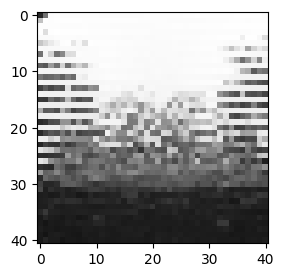

In [35]:
imgMono = np.zeros((dy//sy+1,dx//sx+1,3))
img = np.trapz(SpectImg)
img /= img.max()
for iCh in range(3):
    imgMono[:,:,iCh] = img.reshape((dy//sy+1,dx//sx+1))
    
fig, (ax1) = plt.subplots(1, 1, figsize=(9,3))
im1 = ax1.imshow(imgMono)    

In [36]:
SpectImgN = np.copy(SpectImg)
SpectImgN -= SpectImg.min()
SpectImgN /= SpectImg.max()

In [37]:
opsin_nm = np.load("opsins/wavelengths_nm.npz")["nm"]
tempData = np.load("opsins/human_SML.npz")

opsin_hSI = np.interp(wavelengths_nm, opsin_nm, nan2zero(tempData["s"]))
opsin_hMI = np.interp(wavelengths_nm, opsin_nm, nan2zero(tempData["m"]))
opsin_hLI = np.interp(wavelengths_nm, opsin_nm, nan2zero(tempData["l"]))

plot(wavelengths_nm, opsin_hSI, "b")
plot(wavelengths_nm, opsin_hMI, "g")
plot(wavelengths_nm, opsin_hLI, "r")
plot(wavelengths_nm, SpectImgN[0,0])
ylabel("intensity or sensitivity, norm.")
xlabel("[nm]")

NameError: name 'nan2zero' is not defined

In [38]:
dx, dy, n = SpectImg.shape
imgRGB = np.zeros((dx, dy, 3))

s = opsin_hSI *SpectImgN
img_s = np.trapz(s)
imgRGB[:,:,0] = img_s /img_s.max()
m = opsin_hMI *SpectImgN
img_m = np.trapz(m)
imgRGB[:,:,1] = img_m /img_m.max()
l = opsin_hLI *SpectImgN
img_l = np.trapz(l)
imgRGB[:,:,2] = img_l /img_l.max()

#img /= img.max()
fig, (ax1) = plt.subplots(1, 1, figsize=(9,3))
im1 = ax1.imshow(imgRGB)    

NameError: name 'opsin_hSI' is not defined